In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import linear, relu, sigmoid


from keras.datasets import mnist

import my_utils

np.set_printoptions(precision = 1)



In [107]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [108]:
print(f'The shape of the training example features (X_train): {X_train.shape}')
print(f'The shape of the training example labels   (y_train): {y_train.shape}', end = '\n\n')

print(f'The shape of the test example features (X_test): {X_test.shape}')
print(f'The shape of the test example labels   (y_test): {y_test.shape}')



The shape of the training example features (X_train): (60000, 28, 28)
The shape of the training example labels   (y_train): (60000,)

The shape of the test example features (X_test): (10000, 28, 28)
The shape of the test example labels   (y_test): (10000,)


In [109]:
# Create a cross validation set from the training data to assist in model architecture selection and hyperparameter tuning
cross_validation_size = 10000

X_cv, y_cv = X_train[len(X_train) - cross_validation_size:] , y_train[len(y_train) - cross_validation_size:]
X_train , y_train = X_train[:len(X_train) - cross_validation_size] , y_train[:len(y_train) - cross_validation_size]

print(f'The shape of the validation set features (X_cv): {X_cv.shape}')
print(f'The shape of the validation set labels   (y_cv): {y_cv.shape}', end = '\n\n')

print(f'New shape of the training example features (X_train): {X_train.shape}')
print(f'New shape of the training example labels   (y_train): {y_train.shape}', end = '\n\n')



The shape of the validation set features (X_cv): (10000, 28, 28)
The shape of the validation set labels   (y_cv): (10000,)

New shape of the training example features (X_train): (50000, 28, 28)
New shape of the training example labels   (y_train): (50000,)



In [110]:
#Visualize data structure
print('First 3 Training Examples',X_train[:3],sep = '\n',end = '\n\n\n')
print('Target Labels',y_train[:3],sep = '\n')

First 3 Training Examples
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


Target Labels
[5 0 4]


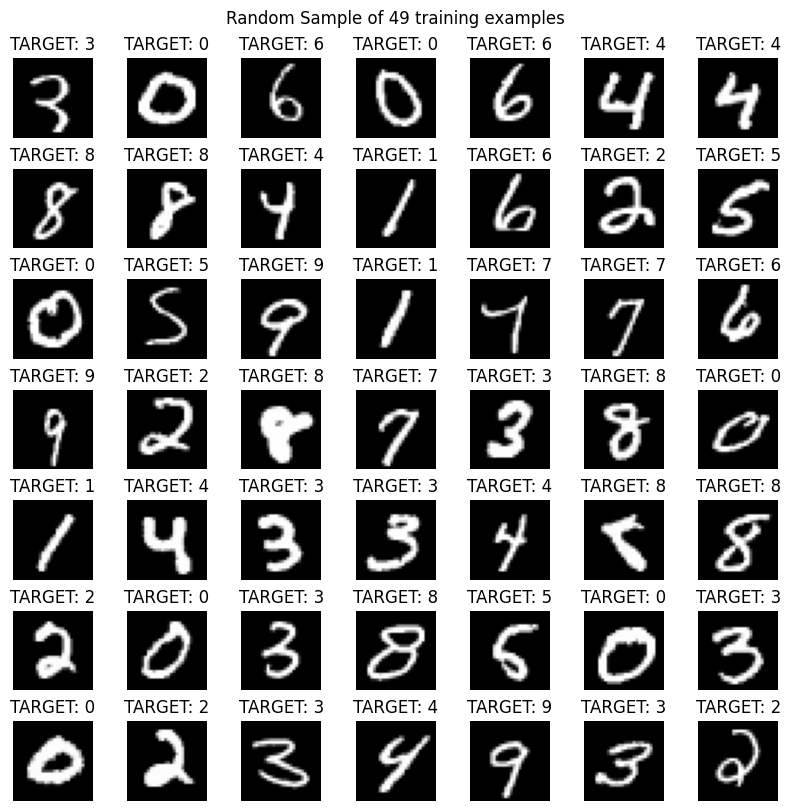

In [111]:
# View a random sampling of data
rows = 7
columns = 7 


random_indices = np.random.choice(a = len(X_train) , size = rows * columns, replace = False)

fig, axes = plt.subplots(rows,columns, constrained_layout = True)

fig.set_size_inches(8,8,forward = True)
fig.set_dpi(100)


train_count = 0
for i in range(7):
    for j in range(7):
        axes[i,j].imshow(X_train[random_indices[train_count]], cmap = 'gray')
        axes[i,j].set_title(f'TARGET: {y_train[random_indices[train_count]]}')
        axes[i,j].axis('off')
        train_count+=1

fig.suptitle(f'Random Sample of {rows * columns} training examples')

plt.show()
        

In [112]:
# Convert 28 x 28 grids of pixes to 1-D array holding sequential pixel intensities
X_train = X_train.reshape(-1,X_train.shape[1] * X_train.shape[2])
X_cv = X_cv.reshape(-1,X_cv.shape[1] * X_cv.shape[2])

X_test = X_test.reshape(-1,X_test.shape[1] * X_test.shape[2])

print(f'Finalized model input feature shape for X_train: {X_train.shape}')
print(f'Finalized model input feature shape for X_cv: {X_cv.shape}')
print(f'Finalized model input feature shape for X_test: {X_test.shape}')

Finalized model input feature shape for X_train: (50000, 784)
Finalized model input feature shape for X_cv: (10000, 784)
Finalized model input feature shape for X_test: (10000, 784)


## Creating Baseline Model 
It may be interesting to create a weak learner model that is essentially logistic regression. 
I will achieve this by creating a basic neural network with NO hidden layers, performing a classic logistic regression problem. 
This will act as a baseline to improve from. 

Performance metrics that will be analyzed:
1. Cost Function (Error Misclassified)
2. F_1 Score
   

In [113]:
baseline_model = Sequential([
    tf.keras.Input(shape = (X_train.shape[1])),
    Dense(units = 10, activation = 'linear', name = 'baseline_output')
], name = 'baseline_model')

In [114]:
baseline_model.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 baseline_output (Dense)     (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [115]:
baseline_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
)

# batch_size was increase to allow for slightly faster computation speed per epoch
epoch_progress = baseline_model.fit(X_train, y_train, epochs = 150,verbose = 1,batch_size = 240)

Epoch 1/150
209/209 [==============================] - 1s 1ms/step - loss: 75.5590
Epoch 2/150
209/209 [==============================] - 0s 1ms/step - loss: 26.4599
Epoch 3/150
209/209 [==============================] - 0s 1ms/step - loss: 15.8522
Epoch 4/150
209/209 [==============================] - 0s 1ms/step - loss: 11.8495
Epoch 5/150
209/209 [==============================] - 0s 1ms/step - loss: 9.7645
Epoch 6/150
209/209 [==============================] - 0s 1ms/step - loss: 8.4661
Epoch 7/150
209/209 [==============================] - 0s 2ms/step - loss: 7.5377
Epoch 8/150
209/209 [==============================] - 0s 2ms/step - loss: 6.8662
Epoch 9/150
209/209 [==============================] - 0s 1ms/step - loss: 6.3071
Epoch 10/150
209/209 [==============================] - 0s 2ms/step - loss: 5.8671
Epoch 11/150
209/209 [==============================] - 0s 1ms/step - loss: 5.4892
Epoch 12/150
209/209 [==============================] - 0s 1ms/step - loss: 5.1703
Epoch 13/

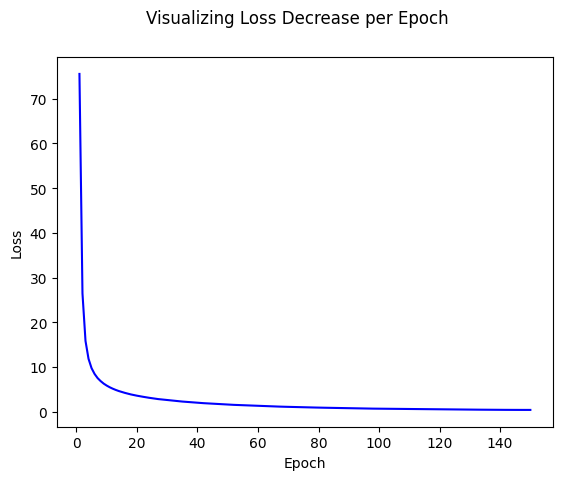

In [116]:
# Plot training curve to ensure accurate decrease of loss per epoch.
# Done to avoid divergence of gradient descent
losses = epoch_progress.history['loss']

plt.close('all')
fig, ax = plt.subplots()

fig.suptitle('Visualizing Loss Decrease per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot(range(1,len(losses)+1), losses, color = 'blue')


The Loss curve above shows signs of continuous decrease, confirming that an appropriate learning rate has been choosen for the baseline model.

NOTE: For the baseline model, a manual grid search approach will be carried out to optimize the parameters. For the later models a more efficient library will be used for hyperparameter tuning. 

### Defining Metric Calculations
Due to the educational nature of this personal project, the metric calculations will be done by hand to demonstrate understanding of key concepts. 
In practice, a library such as sklearn will be used.

In [132]:
metrics = calculate_metrics(baseline_model, X_cv , y_cv)

print(f'{baseline_model.name}\'s ACCURACY             :{metrics.accuracy:.3f}'  , end = '\n\n')
print(f'{baseline_model.name}\'s ERROR                :{1 - metrics.accuracy:.3f}'  , end = '\n\n')

rounded_precisions = [round(num, 3) for num in metrics.F1_score['precision_per_class']]
print(f"{baseline_model.name}'s PRECISION (per class):{rounded_precisions}" ,end = '\n\n' )

rounded_recalls = [round(num, 3) for num in metrics.F1_score['recall_per_class']]
print(f"{baseline_model.name}'s RECALL (per class):{rounded_precisions}"  )


313/313 [==============================] - 0s 912us/step
baseline_model's ACCURACY             :0.897

baseline_model's ERROR                :0.103

baseline_model's PRECISION (per class):[0.908, 0.945, 0.833, 0.866, 0.932, 0.89, 0.92, 0.925, 0.921, 0.835]

baseline_model's RECALL (per class):[0.908, 0.945, 0.833, 0.866, 0.932, 0.89, 0.92, 0.925, 0.921, 0.835]
